# Setting up all the Imports

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from resizeimage import resizeimage

from vgg16_avg import VGG16_Avg
from bcolz_array_iterator import BcolzArrayIterator
limit_mem()


Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

### Read inputs and sanity check

In [2]:
# Resized MS COCO dataset
#arr_lr = bcolz.open('res_72')
arr_hr = bcolz.open('res_288')

In [15]:
print(arr_hr.shape)
inp_shp = arr_hr.shape[1:]

(82783, 288, 288, 3)


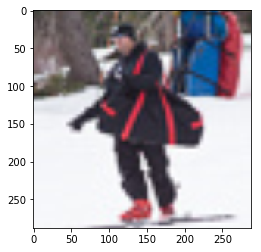

In [3]:
plt.imshow(arr_hr[61420].astype('uint8')) #This is image is the smallest in the dataset.

# Setting up our Neural Network

Some building blocks of our style transfer network. 

In [4]:
# Reflection padding. Found to be helpful for stule transfer
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

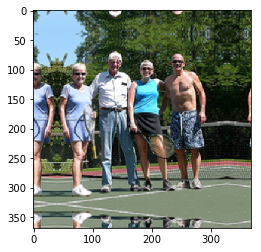

In [9]:
# Test reflection padding
inp = Input(inp_shp)
ref_model = Model(inp, ReflectionPadding2D((40,40))(inp))
ref_model.compile('adam', 'mse')

p = ref_model.predict(arr_hr[10:11])
plt.imshow(p[0].astype('uint8'));

In [10]:
def conv_block(x, num_filters, filter_size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(num_filters, filter_size, filter_size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [11]:
def res_block(ip, num_filters=64):
    x = conv_block(ip, num_filters, filter_size=3, stride=(1,1))
    x = conv_block(x, num_filters, filter_size=3, stride=(1,1), act=False)
    return merge([x, ip], mode='sum')

In [12]:
def up_block(x, num_filters, filter_size, mode='same'):
    x = keras.layers.UpSampling2D()(x)
    x = conv_block(x, num_filters, filter_size, stride=(1,1), mode=mode)
    return x

In [26]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    print(x.shape)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    print(ip.shape)
    return merge([x, ip], mode='sum')

In [27]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
vgg_preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [28]:
vgg_deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [10]:
# Our Super high res CNN that converts a low res image to 4x high res. We will train this.
def get_sr_transfer_nw(arr_lr):
    inp_shape = arr_lr.shape[1:]
    inp=Input(inp_shape)
    x=BatchNormalization(mode=2)(inp)
    x=conv_block(x, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x = up_block(x, 64, 3)
    x = up_block(x, 64, 3)
    x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp, outp

In [11]:
inp, outp = get_sr_transfer_nw(arr_lr)

In [12]:
# Define feature loss network using VGG. Use this to generate feature maps for the ground truth high res images.
# Make sure to set trainable=False for all layers
# This is the VGG16 bundled in Keras. 
output_shape = arr_hr.shape[1:] #Our Super resolution CNN's output shape. Same as the shape of round truth high res images.
vgg_inp = Input(output_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

In [13]:
# tap output of three layers. 
# Flatten each, weight each, and finally concat all three together into one tensor.
l_wts = [0.1, 0.8, 0.1] #Weighted sum
layer_names = ['block2_conv2', 'block3_conv2', 'block4_conv2']
assert len(l_wts)==len(layer_names)

def get_weighted_f_map_tensor(layer_name, weight):
    f_map = Flatten()(vgg.get_layer(layer_name).output)
    f_map = Lambda(lambda x: x*weight)(f_map)
    return f_map

In [14]:
f_map_tensors = [get_weighted_f_map_tensor(layer_name, weight) for layer_name, weight in zip(layer_names, l_wts)]

In [15]:
# concat all three f_maps 
# output_shape=(None, 2654208 + 1327104 + 663552) = (None, 4644864) 
# , concat_axis=1
#concat_axis=-1 by default. Merges along the feature maps dim. Not batch dim.
def get_merged_f_map_tensors(f_map_tensors):
    if len(f_map_tensors)>1:
        merged_f_maps_tensor = merge(f_map_tensors, mode='concat') 
    elif len(f_map_tensors)==1:
        merged_f_maps_tensor = f_map_tensors[0]
    else:
        raise ValueError("f_map_tensors must be a list of tensors")
    
    return merged_f_maps_tensor

In [16]:
merged_f_maps_tensor = get_merged_f_map_tensors(f_map_tensors)
f_maps_model = Model(input=vgg_inp, output=merged_f_maps_tensor)

#quick sanity check
predicted = f_maps_model.predict(arr_hr[0:2], batch_size=2)
predicted.shape

(2, 4644864)

In [17]:
# Define two models using the same computation graph. One for generate feature maps from originals high res images. 
# The other for generating feature maps for the generated high res image
merged_f_maps_tensor = get_merged_f_map_tensors(f_map_tensors)
f_maps_for_originals = Model(input=vgg_inp, output=merged_f_maps_tensor)
f_maps_for_generated = Model(input=vgg_inp, output=merged_f_maps_tensor)(outp)

In [18]:
final_model = Model(inp, output=f_maps_for_generated)

#m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
final_model.compile('adam', 'mse')

In [19]:
# Training: Uncomment to train. ~ 24 hrs on AWS p2. 
# 6 passes with a step size reduction after 3rd pass.

# def train_final_model(bs=32, npasses=1):
#     #targ = np.zeros((bs, 1))
#     its_per_pass = np.ceil(arr_hr.shape[0]/bs)
#     total_its = npasses * its_per_pass
#     bc = BcolzArrayIterator(arr_hr, arr_lr, batch_size=bs)
#     targs = K.variable(np.zeros((bs,4644864)))
#     for i in range(int(total_its)):
#         hr,lr = next(bc)
#         targs = f_maps_for_originals.predict_on_batch(hr)
#         final_model.train_on_batch(lr, targs)

# train_final_model(npasses=3)
#top_model.save_weights('my_sr_final.h5')

# K.set_value(final_model.optimizer.lr, 1e-4)
# train_final_model(npasses=3)
#top_model.save_weights('my_sr_final_step_size_annealing.h5')

In [20]:
top_model = Model(inp, outp)
top_model.load_weights('my_sr_final.h5')
p = top_model.predict(arr_lr[:20])

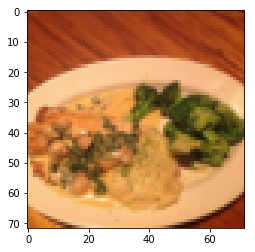

In [66]:
idx=7
# LR input
plt.imshow(arr_lr[idx].astype('uint8'));


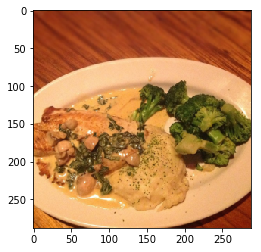

In [67]:
#Original high res
plt.imshow(arr_hr[idx].astype('uint8'));

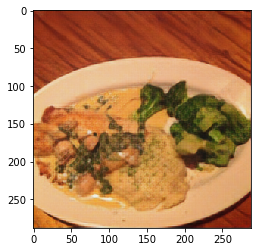

In [68]:
# Generated high res
plt.imshow(p[idx].astype('uint8'));

### Predict on a test image that's NOT in the training data set

In [60]:
from resizeimage import resizeimage

In [61]:
test_image = Image.open('data/trials/input/ys.jpg') #'data/trials/input/ridhi-arjun-119-small.jpg'
test_image_lr = resizeimage.resize_cover(test_image, [72,72])
test_image_hr = resizeimage.resize_cover(test_image, [288,288])

In [62]:
test_image_arr = np.array(test_image_lr)
test_image_arr = np.expand_dims(test_image_arr, 0)

# Change our CNN to accept a different input shape
inp, outp = get_sr_transfer_nw(test_image_arr)

top_model = Model(inp, outp)
top_model.load_weights('my_sr_final.h5')

test_pred = top_model.predict(test_image_arr)

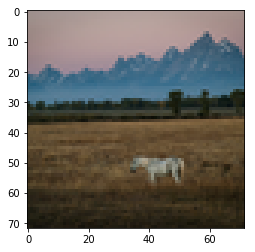

In [63]:
# Low res input
plt.imshow(test_image_arr[0].astype('uint8'));

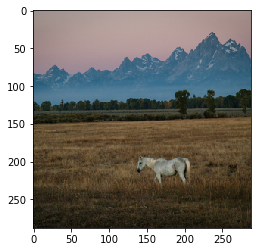

In [64]:
# Original high res file
plt.imshow(np.array(test_image_hr).astype('uint8'));

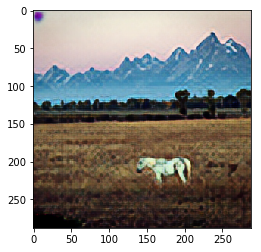

In [65]:
#Generated high res from the model
plt.imshow(test_pred[0].astype('uint8'));